In [1]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from stemsegmentation import segmentationSTEM

In [2]:
mpl.rcParams['figure.dpi'] = 200

In [3]:
from scipy.io import loadmat

In [4]:
#image = np.load('image_2.npy')
#np.savetxt('image_2.txt',image)

In [5]:
image = np.loadtxt('image_2.txt')

([], <a list of 0 Text yticklabel objects>)

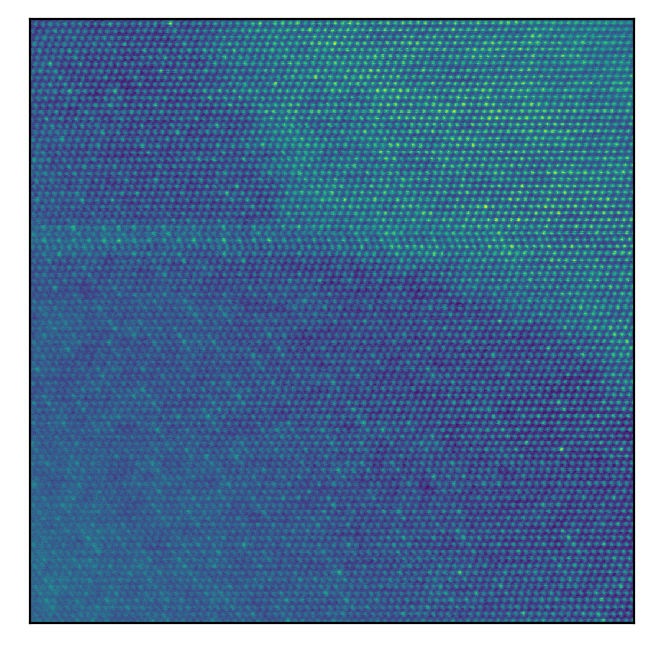

In [6]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])

In [7]:
pixel_size= 0.1761

In [8]:
#atoms = loadmat('image_2_coordinates.mat')
#np.savetxt('image_2_coordinates.txt',atoms['ans'])
#atoms = atoms['ans'] / pixel_size

In [9]:
atoms = np.loadtxt('image_2_coordinates.txt')/pixel_size

In [10]:
tt = atoms[:,0].copy()
atoms[:,0] = 1.*atoms[:,1]
atoms[:,1] = 1.*tt
atoms = atoms[:,0:2]

In [11]:
add_atoms = np.array(([[939,29],[941,55],[859,120]]))

In [12]:
atoms = np.concatenate( [atoms,add_atoms], axis=0)

In [13]:
del tt

In [14]:
#https://lammps.sandia.gov/doc/compute_centro_atom.html
normalization = True
number_neigh = 8
int_half = int(number_neigh/2)
descriptors = np.zeros(len(atoms))
for i,atom in enumerate(atoms):
    distances = np.linalg.norm( atoms[:] - atom,axis=1)
    neighbours = np.argpartition(distances, number_neigh)[:(number_neigh+1)]
    neighbours = np.delete(neighbours, np.where(neighbours==i))
    pairs = []
    if normalization == True:
        v1_all = []
        v2_all = []
    for j in range(len(neighbours)):
        for k in range(j+1,len(neighbours)):
            v1 = atoms[neighbours[j]] - atom
            v2 = atoms[neighbours[k]] - atom
            if normalization == True:
                v1_all.append(v1)
                v2_all.append(v2)
            sum12 = v1+v2
            pairs += [ np.sum(sum12*sum12),]
    pairs = np.array(pairs)
    indices = np.argsort(pairs)[:int_half]
    if normalization is False:
        descriptors[i] = np.sum(pairs[indices])
    else:
        v1_all = np.array(v1_all)
        v2_all = np.array(v2_all)
        up = np.sum(pairs[indices])
        tt = np.array(v1_all[indices])
        down = 2.*np.sum(tt*tt)
        tt = np.array(v2_all[indices])
        down += 2.*np.sum(tt*tt)
        descriptors[i] = up/down

In [15]:
from scipy import interpolate

In [16]:
shape = image.shape
x,y = np.meshgrid(np.arange(shape[0]),np.arange(shape[1]))
x = x.T
y = y.T
row = x.flatten()
col  = y.flatten()
coords = np.vstack((row, col)).T

In [17]:
a = interpolate.griddata(atoms[:,0:2],descriptors,coords,method='cubic')

In [18]:
a = np.reshape(a, shape)

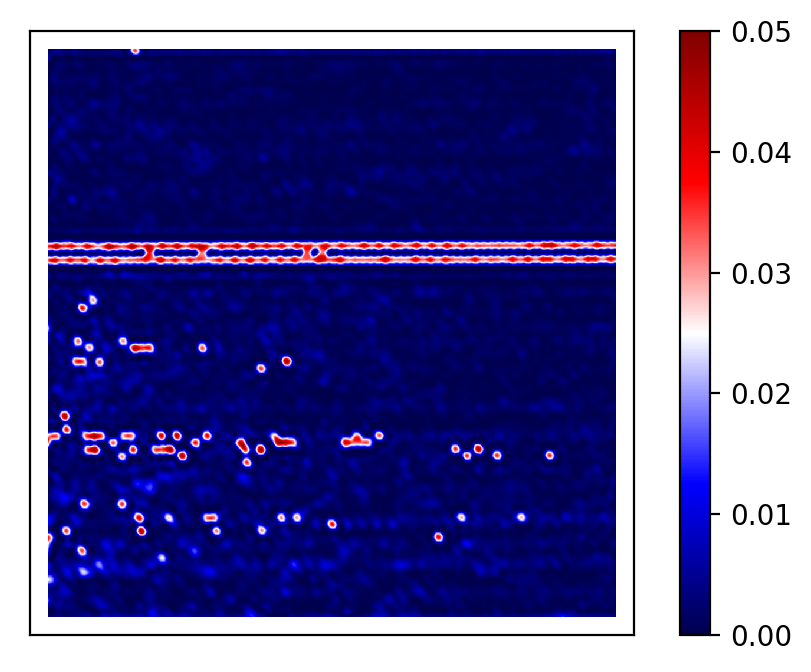

In [19]:
import matplotlib
border = 30
a[0:border,:] = np.nan
a[:,0:border] = np.nan
a[(shape[0]-border):,:] = np.nan
a[:,(shape[0]-border):] = np.nan
fig, ax = plt.subplots()
im = plt.imshow(a,cmap=matplotlib.cm.seismic,vmin=0,vmax=0.05)
#plt.imshow(a[border:(1024-border),border:(1024-border)],cmap=matplotlib.cm.seismic)
plt.xticks([])
plt.yticks([])
fig.colorbar(im, ax=ax)

In [20]:
image_norm = image / np.max(image)

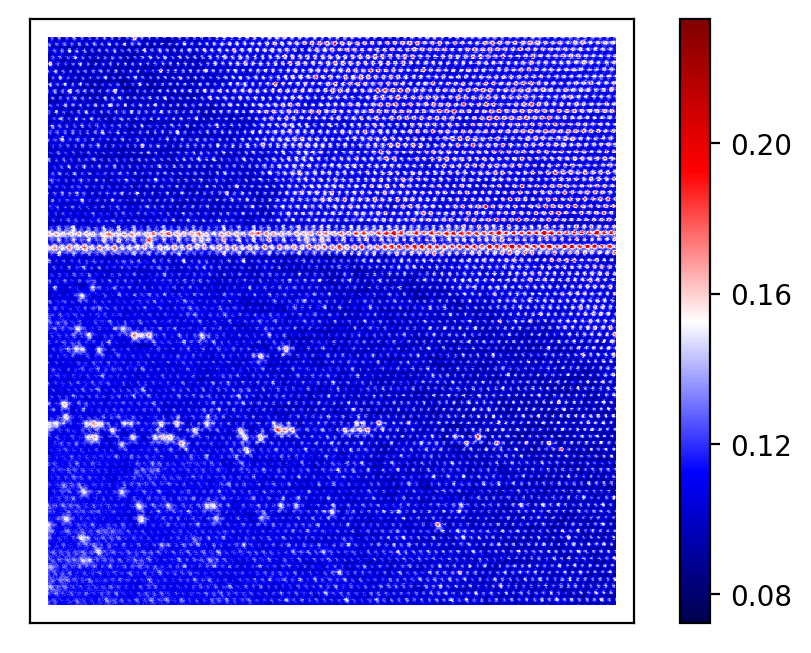

In [27]:
import matplotlib
border = 30
a[0:border,:] = np.nan
a[:,0:border] = np.nan
a[(shape[0]-border):,:] = np.nan
a[:,(shape[1]-border):] = np.nan
b = a.copy()
b[border:(shape[0]-border),border:(shape[1]-border)] = b[border:(shape[0]-border),border:(shape[1]-border)]+0.2*(image_norm[border:(shape[0]-border),border:(shape[1]-border)])
fig, ax = plt.subplots()
im = plt.imshow(b,cmap=matplotlib.cm.seismic)
#im = plt.imshow(b,cmap=matplotlib.cm.seismic,vmin=0,vmax=0.05)
#plt.imshow(a[border:(1024-border),border:(1024-border)],cmap=matplotlib.cm.seismic)
plt.xticks([])
plt.yticks([])
fig.colorbar(im, ax=ax,ticks=[0.08,0.12,0.16,0.2])

([], <a list of 0 Text yticklabel objects>)

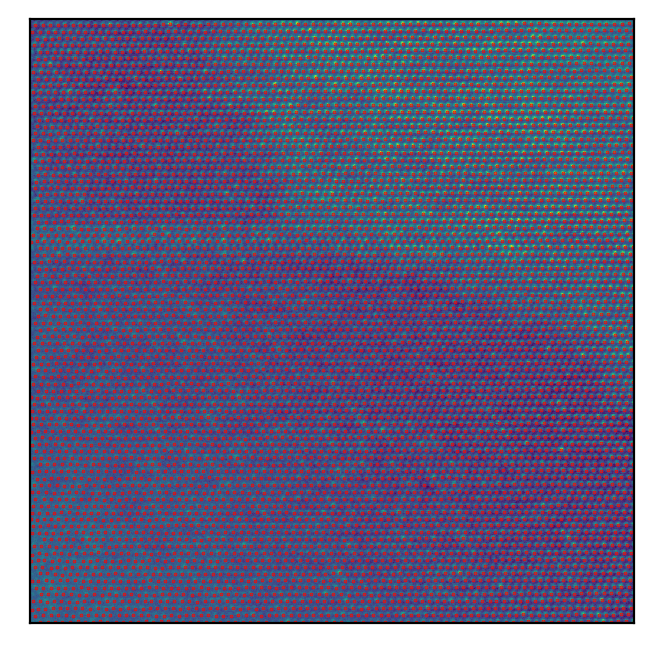

In [48]:
plt.imshow(image)
plt.plot(atoms[:,1],atoms[:,0],'ro',markersize=0.3)
plt.xlim(0,1024)
plt.xticks([])
plt.yticks([])
#plt.plot([120],[859],'bo',markersize=4)
#plt.plot([55],[941],'bo',markersize=4)
#plt.xlim(100,200)
#plt.ylim(800,900)

In [52]:
methods_implemented = ['simplified','full']
def generate_synthetic_image(image,atoms,atomic_size=6,method='simplifed'):
    synthetic_image = np.zeros_like(image, dtype=np.float32)
    if method is 'simplified':
        atoms = atoms.astype(np.int32)
        sigma = 0.5*atomic_size
        int_s = int(sigma)
        int_s = max(int_s, 1)
        cutoff = 5
        x,y = np.meshgrid(np.arange(2*cutoff*int_s+1),np.arange(2*cutoff*int_s+1))
        center_x = cutoff*int_s
        center_y = cutoff*int_s
        gaussian = np.exp(-((x-center_x)**2 + (y-center_y)**2)/(2*sigma**2))
        shape = image.shape
        for atom in atoms:
            if atom[0] - cutoff*int_s < 0:
                x_len_l = atom[0]
            else:
                x_len_l = cutoff*int_s
            
            if atom[0] + cutoff*int_s > shape[0]-1:
                x_len_r = shape[0]-1 - atom[0]
            else:
                x_len_r = cutoff*int_s
            
            if atom[1] - cutoff*int_s < 0:
                y_len_l = atom[1]
            else:
                y_len_l = cutoff*int_s
            
            if atom[1] + cutoff*int_s > shape[1]-1:
                y_len_r = shape[1]-1 - atom[1]
            else:
                y_len_r = cutoff*int_s 
            synthetic_image[(atom[0]-x_len_l):(atom[0]+x_len_r+1),(atom[1]-y_len_l):(atom[1]+y_len_r+1)]  +=\
                gaussian[(center_x-x_len_l):(center_x+x_len_r+1),(center_y-y_len_l):(center_y+y_len_r+1)]
    else:
        sigma = 0.5*atomic_size
        cutoff = 5
        shape = image.shape
        for atom in atoms:
            x_l = max(int(atom[0]-5*sigma),0)
            x_r = min(int(atom[0]+5*sigma),shape[0]-1)
            y_l = max(int(atom[1]-5*sigma),0)
            y_r = min(int(atom[1]+5*sigma),shape[1]-1)
            x,y = np.meshgrid(np.arange(x_l,x_r+1), np.arange(y_l,y_r+1))
            x = x.T
            y = y.T
            synthetic_image[x_l:(x_r+1),y_l:(y_r+1)] += np.exp( -((x-atom[0])**2+(y-atom[1])**2)/(2*sigma**2) )
    return synthetic_image
    #return gaussian

In [53]:
synthetic_image = generate_synthetic_image(image,atoms,method='full')

([], <a list of 0 Text yticklabel objects>)

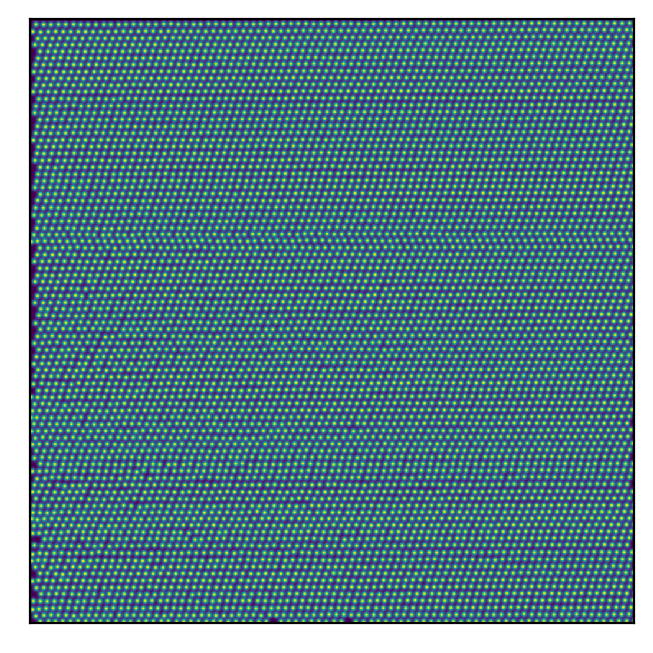

In [54]:
plt.imshow(synthetic_image[:,:])
plt.xticks([])
plt.yticks([])